#### This notebook takes filtered and averaged shelf data and performs an MCA Analysis.
#### Plots of the temporal and spatial modes are also made in this script

In [1]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/scripts')
plotsdir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/plots/" + x
GLORYS_dir = lambda x="": "/vortexfs1/texfs1/home/anthony.meza/GLORYS_data" + x
GLORYS_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/GLORYS_processed/" + x
ERA5_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/ERA5_data/" + x

In [2]:
import numpy as np
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import gc, os, copy, pickle, datetime
import os 
from os.path import exists
from scipy import signal
import copy
from scipy.signal.windows import tukey
from scipy import linalg
import pickle
import datetime
import seaborn as sns 
sns.set_context("talk")
colors = [sns.color_palette("tab10")[i] for i in [4, 3, 0]]

In [4]:
#will plot relevant locations to a line plot
normalize = lambda x: (x - np.mean(x)) / np.std(x)
def plot_geovlines(labels_dict, ax):
    ax2 = ax.twiny()
    locs=[]
    labels = []
    ylims = ax.get_ylim()
    for (key, value) in labels_dict.items():
        ax2.axvline(value, c = "grey", zorder = 0)
        locs+=[value]
        labels+=[key]
    ax2.set_xticklabels(labels)
    ax2.set_xticks(locs)
    ax2.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])
def extract_EOFs(u, var_spacing, varnames):
    EOFs_dict = {}
    for (i, varname) in enumerate(varnames):
        EOFs_dict[varname] = {}
        for j in range(0, 2):
            EOFs_dict[varname]["EOF" + str(j+1)] = u[i*var_spacing:(i+1)*var_spacing, j];
    return EOFs_dict
def extract_normalized_PCs(u, Y):
    PC_dict = {}
    for i in range(0, 2):
        U = u[:, i:i+1];
        PC_dict["PC"+str(i+1)] = normalize(U.T @ Y).flatten() #get expansion coefs for first EOF
    return PC_dict
def extract_normalized_MCs(u, Y):
    PC_dict = {}
    for i in range(0, 2):
        U = u[:, i:i+1];
        PC_dict["PC"+str(i+1)] = normalize(Y.T @ U).flatten() #get expansion coefs for first EOF
    return PC_dict
def index_amplitude(PC_dict):
    return np.sqrt(PC_dict["PC1"]**2 + PC_dict["PC2"]**2)
def avg_dict(d1, d2):
    d = {}
    for key in d1.keys():
        d[key] = 0.5 * (d1[key] + d2[key])
    return d
correlate = lambda x1, x2: np.sum(normalize(x1) * normalize(x2)) / len(x1)


### Reading in the GLORYS and ERA5 data files. Files have been preprocessed and combined in order to take advantage of the **dask** feature of xarray. We also remove their seasonal cliamtologies

In [5]:
anomalies_filtered_kandf = xr.open_dataset(GLORYS_data_dir("GLORYS_Coastal_Vars_Anomalies_SpaceTimeFiltered.nc"))
hovmoller_ds = xr.open_dataset(GLORYS_data_dir("GLORYS_Coastal_Path.nc")).compute()

In [6]:
distances = hovmoller_ds.distance.values
findminlat = lambda lat, lat0: np.argmin((lat - lat0)**2)

#computes the distance from "SA"
distance_labels = {}
distance_labels["SA"] = np.max(hovmoller_ds.EQ.values * distances)
distance_labels["GC W"] = distances[hovmoller_ds.GC_C.values.astype("bool")].mean()
distance_labels["GC E"] = distances[hovmoller_ds.GC_E.values.astype("bool")].max() - (distance_labels["GC W"] - distances[hovmoller_ds.GC_C.values.astype("bool")].min())
distance_labels["LA"] = distances[findminlat(hovmoller_ds.lat_path.values, 33)]
distance_labels["SF"] = distances[findminlat(hovmoller_ds.lat_path.values, 38)]


# Store data of distance labels
with open(GLORYS_data_dir("GLORYS_CoastalLocations.pickle"), 'wb') as handle:
    pickle.dump(distance_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [9]:
#zero out the equator, only keep coastal points 
coast_mask = anomalies_filtered_kandf.distance.values
coast_mask = (coast_mask > distance_labels["SA"]).astype("int")

#mask the data 
filtered_masked = anomalies_filtered_kandf.compute()
filtered_masked = filtered_masked.isel(distance = np.where(coast_mask)[0])
filtered_masked["distance"] = filtered_masked["distance"] - filtered_masked.distance.values[0]

#remove secular trends and normalize the data
pf = filtered_masked.polyfit(dim = "time", deg=1, skipna = False)
trends = xr.polyval(filtered_masked.time, pf)
filtered_trends = trends.rename({"thetao_polyfit_coefficients":"thetao", "zos_polyfit_coefficients":"zos"})
filtered = (filtered_masked - filtered_trends) #remove linear trends from all variables 
filtered_std = filtered.std("time").mean(dim = "distance") #spatial mean
filtered = filtered / filtered_std
filtered = filtered.compute()

In [10]:
xdistances = filtered.distance.values - filtered.distance.values[0]
xdistance_labels = {k:v -distance_labels["SA"]  for k, v in distance_labels.items()}

In [11]:
#SSH and Mixed Layer Maximum Covariance Analysis
X = filtered.zos.values.T; Y  = filtered.thetao.values.T
XY_SSHandMxLyer = X @ Y.T / len(filtered.zos.time)
SVD_SSHandMxLyer  = linalg.svd(XY_SSHandMxLyer, full_matrices= False) #do svd 

#Mixed Layer EOF
Y_MxLyer = filtered.thetao.values.T #Y is space x time
SVD_MxLyer = linalg.svd(Y_MxLyer, full_matrices= False) #do svd 

#SSH EOC
Y_SSH = filtered.zos.values.T
SVD_SSH = linalg.svd(Y_SSH, full_matrices= False) #do svd 

In [14]:
var_spacing = len(filtered_masked.distance) #each of has the length of distance

(u, s, vh) = SVD_SSHandMxLyer
EOFs_SM = extract_EOFs(u, var_spacing, ["SSHand40mtemp"]) 
EOFs_SM_temp = extract_EOFs(vh.T, var_spacing, ["SSHand40mtemp"]) 

PCs_SM_MxTmp = extract_normalized_MCs(vh.T, Y) 
PCs_SM_SSH = extract_normalized_MCs(u, X) 
PCs_SM = PCs_SM_MxTmp

(u, s, vh) = SVD_MxLyer
EOFs_M = extract_EOFs(u, var_spacing, ["40mtemp"]) 
PCs_M = extract_normalized_PCs(u, Y_MxLyer) 

(u, s, vh) = SVD_SSH
EOFs_S = extract_EOFs(u, var_spacing, ["SSH"]) 
PCs_S = extract_normalized_PCs(u, Y_SSH) 

index_labels = ["SSH and Mixed Layer Temp. Coastal Wave Index", "Mixed Layer Temp. Coastal Wave Index", "SSH Coastal Wave Index"]

In the following block of code, we plot the first two spatial modes of SSH obtained from the EOFs and the MCA 

/tmp/ipykernel_170811/3819671281.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels)


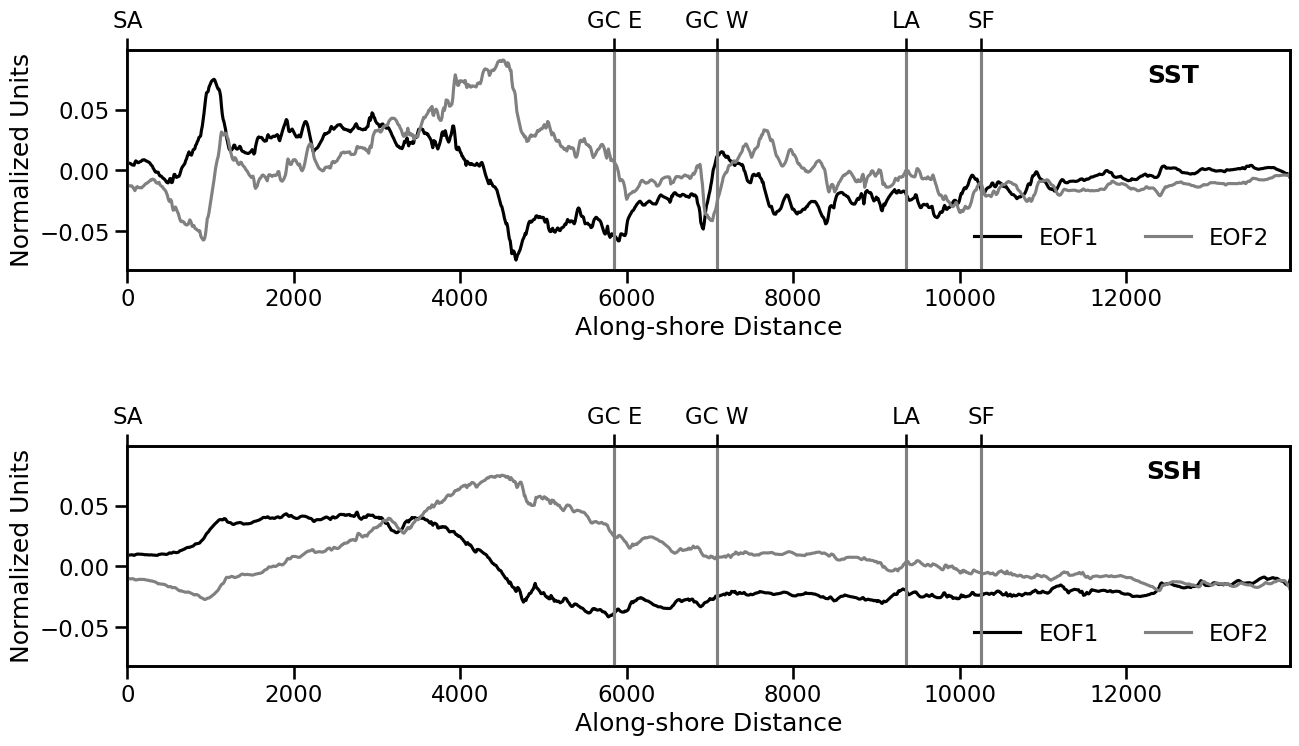

In [18]:
fig1, ax = plt.subplots(2, 1, figsize = (15, 8), sharey = True)

cs = ["black", "grey"]
flip_sign1 = [-1, 1]
flip_sign2 = [-1, 1]
for (i, eof) in enumerate(["EOF1", "EOF2"]):
    ax[0].plot(xdistances, EOFs_SM_temp["SSHand40mtemp"][eof] * flip_sign1[i], c = cs[i], label = eof)
    ax[1].plot(xdistances, EOFs_SM["SSHand40mtemp"][eof] * flip_sign2[i], c = cs[i], label = eof)

ax[1].legend()
[a.set_xlabel("Along-shore Distance") for a in ax]
[a.set_ylabel("Normalized Units") for a in ax]
[a.set_xlim(xdistances.min(), xdistances.max()) for a in ax]

ax[0].legend(loc='lower right',ncol=2, frameon = False)
ax[1].legend(loc='lower right',ncol=2, frameon = False)
fig1.subplots_adjust(hspace = 0.8)

ax[0].text(0.9, 0.85, "SST", 
                  transform=ax[0].transAxes, horizontalalignment = "center", fontweight = "bold")
ax[1].text(0.9, 0.85, "SSH", 
                  transform=ax[1].transAxes, horizontalalignment = "center", fontweight = "bold")

plot_geovlines(xdistance_labels, ax[0])
plot_geovlines(xdistance_labels, ax[1])

fig1.savefig(plotsdir("generals/EOFs.png"), bbox_inches = "tight")

Next we plot the cross-correlation between the first two temporal modes obtained from the EOFs 

0.8218894866686429
-12
0.8929735651785726
-12


(-1.0, 1.0)

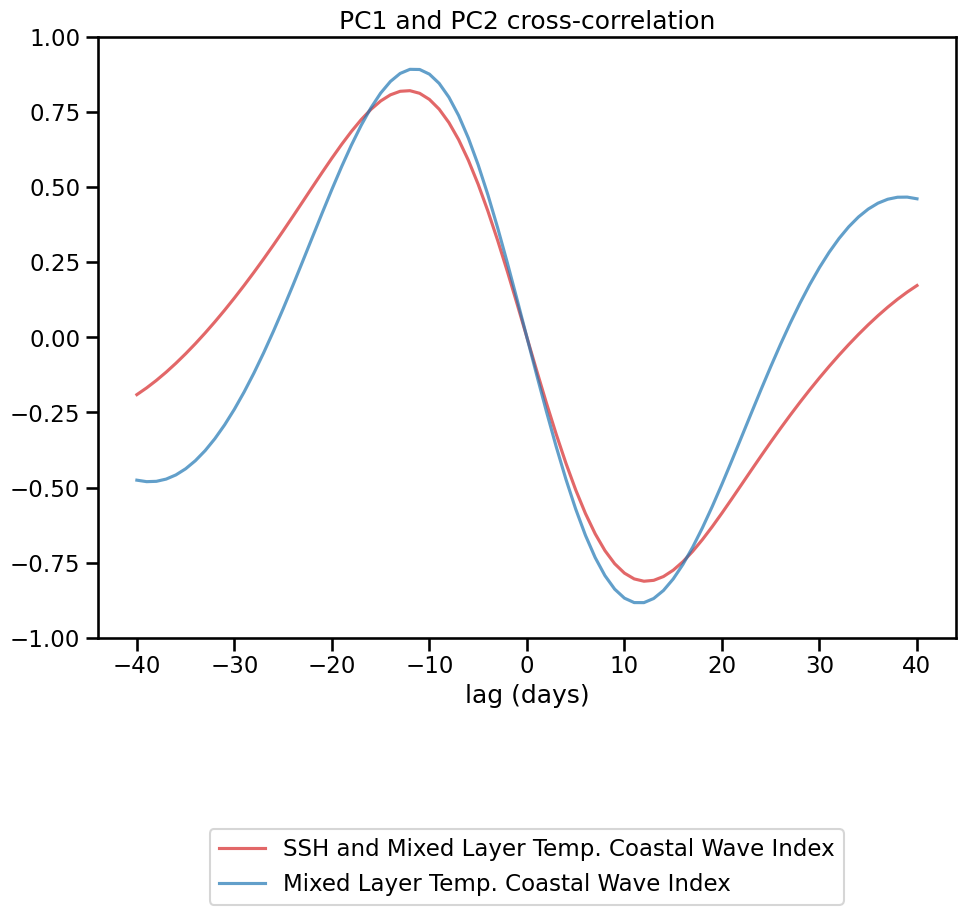

In [107]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

#Plot the cross correlation
PCs = [PCs_M, PCs_S]
flip_PC1 = [-1,-1, -1]
flip_PC2 = [1,1, 1]
alphas = [1, 0.7,0.7]
for (i, PC) in enumerate(PCs):
    output = ax.xcorr(PC["PC1"] * flip_PC1[i], PC["PC2"] * flip_PC2[i], maxlags=40, usevlines = False, normed=True, alpha=0.0)
    print(output[1].max())
    print(output[0][output[1].argmax()])
    ax.plot(output[0], output[1], label = index_labels[i], c = colors[i+1], alpha=alphas[i+1])
ax.legend()
ax.set_title("PC1 and PC2 cross-correlation")
ax.set_xlabel("lag (days)")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          ncol=1)
fig.tight_layout()
ax.set_ylim(-1, 1)

In [ ]:
print("Mixed Layer Temperature Correlations")
print("PC1")
print(100 * correlate(PCs_SM_MxTmp["PC1"], PCs_M["PC1"]))
print("PC2")
print(100 * correlate(PCs_SM_MxTmp["PC2"], PCs_M["PC2"]))
print("EOF1")
print(100 * correlate(EOFs_SM_temp["SSHand40mtemp"]["EOF1"], EOFs_M["40mtemp"]["EOF1"]))
print("EOF2")
print(100 * correlate(EOFs_SM_temp["SSHand40mtemp"]["EOF2"], EOFs_M["40mtemp"]["EOF2"]))

print("SSH Correlations")
print("PC1")
print(100 * correlate(PCs_SM_SSH["PC1"], PCs_S["PC1"]))
print("PC2")
print(100 * correlate(PCs_SM_SSH["PC2"], PCs_S["PC2"]))
print("EOF1")
print(100 * correlate(EOFs_SM["SSHand40mtemp"]["EOF1"], EOFs_S["SSH"]["EOF1"]))
print("EOF2")
print(100 * correlate(EOFs_SM["SSHand40mtemp"]["EOF2"], EOFs_S["SSH"]["EOF2"]))


98.61166407334757
98.57997287987493
95.62868202671751
95.37391353243376
